# Text Classification in NLP using Movie reviews data

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [66]:
df = pd.read_csv('moviereviews.csv')

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   2000 non-null   object
 1   review  1965 non-null   object
dtypes: object(2)
memory usage: 31.4+ KB


In [68]:
df.head()

,label,review
0,neg,how do films like mouse hunt get into theatres...
1,neg,some talented actresses are blessed with a dem...
2,pos,this has been an extraordinary year for austra...
3,pos,according to hollywood movies made in last few...
4,neg,my first press screening of 1998 and already i...


**Data Cleaning**
- remove missing values
- remove blank reviews

In [69]:
# Check for missing values
df.isnull().sum()

label      0
review    35
dtype: int64

In [70]:
# Remove missing reviews
df.dropna(inplace=True)

In [71]:
# Check for blank reviews
df['review'].str.isspace().sum()

27

In [72]:
# Remove blank reviews
df = df[~(df['review'].str.isspace())]

In [73]:
# Check distribution of reviews
df['label'].value_counts()

neg    969
pos    969
Name: label, dtype: int64

**Count vectorizing and EDA**
- Search for common genres in reviews to estimate genre-distribution of reviews
- Check overlap of genres using correlation; comedy and romance have greater overlap (as expected due to rom-coms)
- Check if length of review differs by positive/negative reviews
- Check most common words in positive/negative reviews

In [74]:
# Genres in reviews
genres = ["comedy", "horror", "romance", "action"]

In [75]:
for i in genres:
    df[i] = np.where(df['review'].str.contains(i),1,0)

In [76]:
df.loc[:,"comedy":].sum(axis=0)

comedy     492
horror     231
romance    139
action     755
dtype: int64

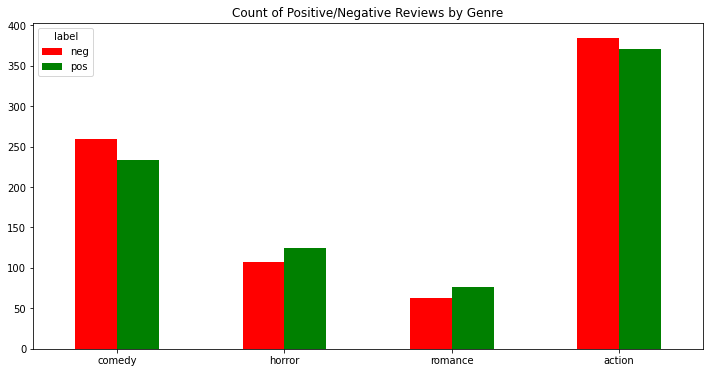

In [77]:
df.groupby("label")[["comedy", "horror", "romance", "action"]].sum().T.plot.bar(rot=0, figsize=(12, 6), color = ["red","green"], title="Count of Positive/Negative Reviews by Genre");

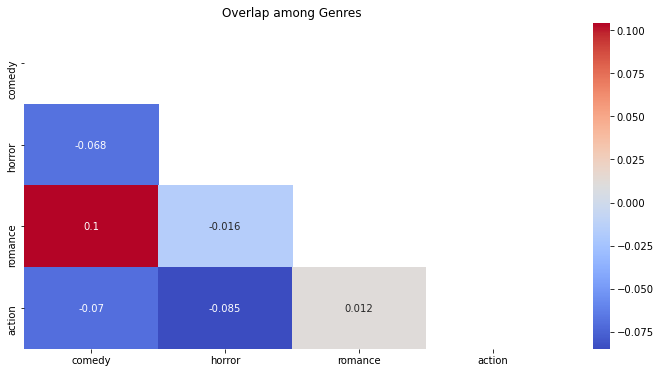

In [78]:
# Overlap among genres
corr = df.loc[:,"comedy":].corr()

matrix = np.triu(corr)

plt.figure(figsize=(12,6))
sns.heatmap(corr, annot=True, mask=matrix, cmap="coolwarm")
plt.title("Overlap among Genres");

In [79]:
# Length of review by positive/ngeative reviews
df_2 = df.copy()

In [80]:
df_2["Length_of_Review"] = df_2['review'].apply(len)

In [81]:
# Check summary statistics of Review Length by Positive/Negative review
round(df_2.groupby("label")["Length_of_Review"].describe().T,1)

label,neg,pos
count,969.0,969.0
mean,3659.2,4120.7
std,1514.2,1830.9
min,92.0,732.0
25%,2680.0,2852.0
50%,3455.0,3859.0
75%,4423.0,5020.0
max,11520.0,15016.0


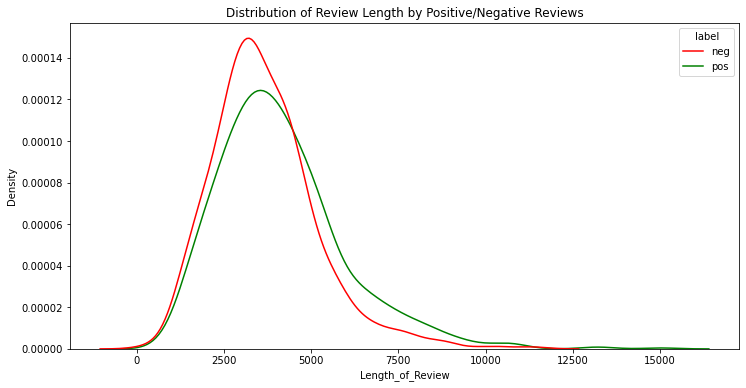

In [82]:
plt.figure(figsize=(12,6))
sns.kdeplot(data=df_2,x='Length_of_Review',hue='label',palette=["red","green"])
plt.title("Distribution of Review Length by Positive/Negative Reviews");

In [83]:
# Count vectorizing
from sklearn.feature_extraction.text import CountVectorizer

In [84]:
# Remove common words and punctuation
cv = CountVectorizer(stop_words='english')

In [85]:
df = df.loc[:,["label","review"]]

In [86]:
# Check most common words in positive and negative reviews
pos_review = cv.fit_transform(df[df['label']=='pos']['review'])
pos_review_dict = dict(zip(cv.get_feature_names(), pos_review.sum(axis=0).tolist()[0]))  

neg_review = cv.fit_transform(df[df['label']=='neg']['review'])
neg_review_dict = dict(zip(cv.get_feature_names(), neg_review.sum(axis=0).tolist()[0]))   

In [87]:
pos_review_top10 = pd.DataFrame(sorted(pos_review_dict.items(), key = lambda i:(-i[1]))[:10], columns = ["word", "count"])
neg_review_top10 = pd.DataFrame(sorted(neg_review_dict.items(), key = lambda i:(-i[1]))[:10], columns = ["word", "count"])

In [88]:
pos_review_top10["review"] = "Positive"
neg_review_top10["review"] = "Negative"

In [89]:
review_top10 = pd.concat([pos_review_top10,neg_review_top10], axis = 0)

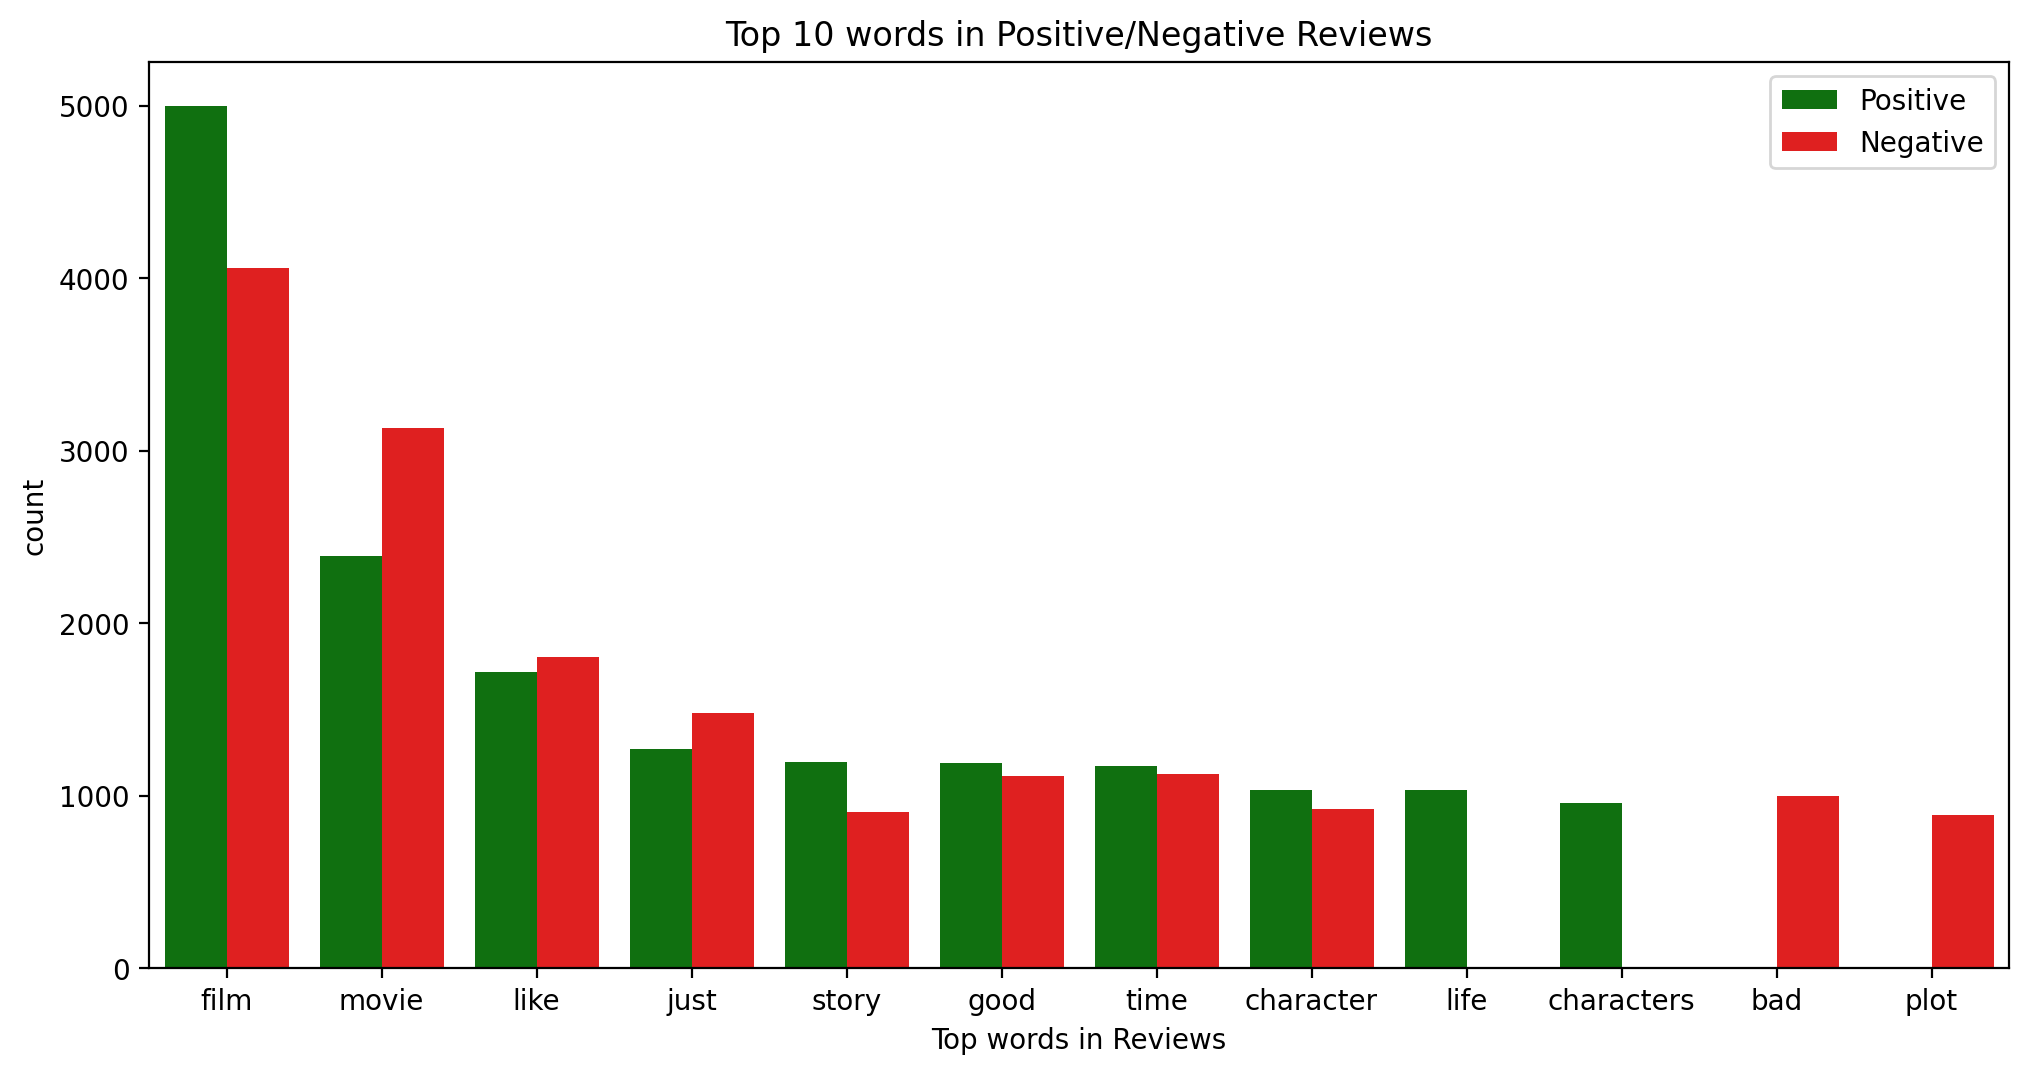

In [90]:
plt.figure(figsize=(12,6),dpi=200)
sns.barplot(data = review_top10, x = "word", y = "count", hue = "review", palette=["green","red"])
plt.xlabel("Top words in Reviews")
plt.legend(loc='upper right')
plt.title("Top 10 words in Positive/Negative Reviews");

**Model Training**

In [91]:
from sklearn.model_selection import train_test_split

X = df['review']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=333)

In [92]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,plot_confusion_matrix,accuracy_score

In [93]:
# function to generate TF-IDF, fit model and check confusion matrix
def run_model(model_name, model):
    pipe = Pipeline([('tfidf', TfidfVectorizer()),(model_name, model)])
    pipe.fit(X_train, y_train)  
    preds = pipe.predict(X_test)
    acc = round(accuracy_score(y_test,preds),2)
    
    print("Accuracy for",model_name,":",acc,"\n")
    print(classification_report(y_test,preds))
    plot_confusion_matrix(pipe,X_test,y_test)
    
    
    

Accuracy for Linear SVC : 0.86 

              precision    recall  f1-score   support

         neg       0.88      0.83      0.85       187
         pos       0.85      0.89      0.87       201

    accuracy                           0.86       388
   macro avg       0.86      0.86      0.86       388
weighted avg       0.86      0.86      0.86       388



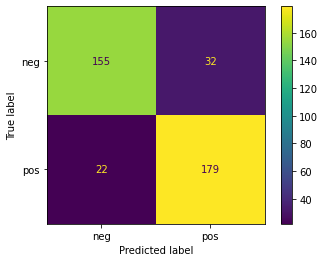

In [94]:
# Checking different models
run_model('Linear SVC',LinearSVC())

Accuracy for MN-NB : 0.79 

              precision    recall  f1-score   support

         neg       0.72      0.90      0.80       187
         pos       0.88      0.68      0.77       201

    accuracy                           0.79       388
   macro avg       0.80      0.79      0.78       388
weighted avg       0.80      0.79      0.78       388



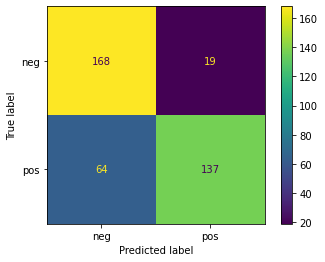

In [95]:
run_model('MN-NB',MultinomialNB())

Accuracy for Random Forest : 0.81 

              precision    recall  f1-score   support

         neg       0.76      0.87      0.81       187
         pos       0.86      0.75      0.80       201

    accuracy                           0.81       388
   macro avg       0.81      0.81      0.81       388
weighted avg       0.81      0.81      0.81       388



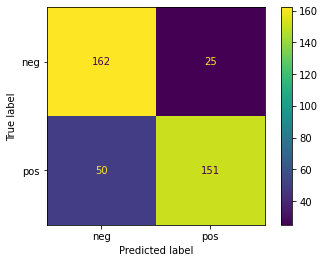

In [96]:
run_model('Random Forest',RandomForestClassifier())

In [97]:
# Test some model adjustments
def run_model_v2(model_name, model):
    pipe = Pipeline([('tfidf', TfidfVectorizer(max_df = 0.5, min_df = 2, ngram_range = (1,2))),(model_name, model)])
    pipe.fit(X_train, y_train)  
    preds = pipe.predict(X_test)
    acc = round(accuracy_score(y_test,preds),2)
    
    print("Accuracy for",model_name,":",acc,"\n")
    print(classification_report(y_test,preds))
    plot_confusion_matrix(pipe,X_test,y_test)

Accuracy for Linear SVC : 0.89 

              precision    recall  f1-score   support

         neg       0.92      0.84      0.88       187
         pos       0.86      0.93      0.89       201

    accuracy                           0.89       388
   macro avg       0.89      0.88      0.89       388
weighted avg       0.89      0.89      0.89       388



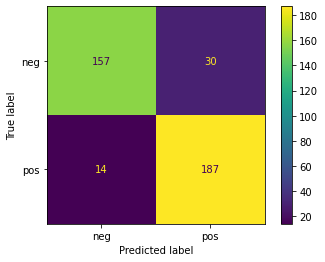

In [98]:
run_model_v2('Linear SVC',LinearSVC())

In [99]:
# Test final model 
pipe = Pipeline([('tfidf',TfidfVectorizer(max_df = 0.5, min_df = 2, ngram_range = (1,2))),('svc',LinearSVC())])
pipe.fit(X, y)  
pipe.predict(["too long and boring", "excellent cast and story"])

array(['neg', 'pos'], dtype=object)